In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import linregress
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
import numpy as np

dataset_path = 'AAPL_new_sep_time.csv'
chunksize = 100000
tfr = pd.read_csv(dataset_path, chunksize=chunksize, iterator=True)
read_df = pd.concat(tfr, ignore_index=True)

read_df.head()

,Unnamed: 0,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date-Time_ntz,Date,Time,Direction
0,0,AAPL.OQ,Market Price,2023-09-01 09:30:00.001188961-04:00,Trade,189.57,300.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.001188961,2023-09-01,09:30:00.001188,NaN
1,1,AAPL.OQ,Market Price,2023-09-01 09:30:00.006152553-04:00,Trade,189.57,1221.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.006152553,2023-09-01,09:30:00.006152,NaN
2,2,AAPL.OQ,Market Price,2023-09-01 09:30:00.011164045-04:00,Trade,189.57,100.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.011164045,2023-09-01,09:30:00.011164,NaN
3,3,AAPL.OQ,Market Price,2023-09-01 09:30:00.011164045-04:00,Trade,189.57,159.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.011164045,2023-09-01,09:30:00.011164,NaN
4,4,AAPL.OQ,Market Price,2023-09-01 09:30:00.011164045-04:00,Trade,189.57,50.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.011164045,2023-09-01,09:30:00.011164,NaN


In [36]:
def clean_data(or_df):
    """
    Data cleansing
    Parameters
    ----------
    or_df : pd.DataFrame
    DataFrame containing the original data before cleansing
    Returns
    -------
    cleaned : pd.DataFrame
    DataFrame containing the original data after cleansing
    """
    # Fill empty Bid and Ask price based on previous price
    or_df.sort_values('Seq', inplace=True)
    or_df[['Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']] = or_df[['Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']].fillna(method='ffill')

    # Filter 1: Transaction price is greater than the prevailing best ask price
    or_df.drop(or_df[(or_df['Type'] == 'Trade') & (or_df['Price'] > or_df['Ask Price'])].index, inplace=True)
    
    # Filter 2: The quoted bid price exceeds the quoted ask price
    or_df.drop(or_df[(or_df['Type'] == 'Quote') & (or_df['Bid Price'] > or_df['Ask Price'])].index, inplace=True)
    
    # Filter 3: Observations occurring before 09:30:00 or
    # after 16:00:00 Eastern Time
    or_df = or_df.between_time('09:30:00', '16:00:00')
    return or_df

def create_trade_df(df):
    """
    Create trade dataframe, and add:
    - Mid-quote
    - Tick direction based on mid_quote and price changes
    - Quoted Spread
    - Effective Spread
    Parameters
    ----------
    df : pd.DataFrame
    DataFrame containing the original data
    Returns
    -------
    trade_df : pd.DataFrame
    DataFrame containing trade data with the new attributes
    """
    # Create a new DataFrame containing only trade data
    trade_df = df[df["Type"] == "Trade"].sort_index().copy()
    
    # Add the 'mid_quote' column
    trade_df['mid_quote'] = (trade_df['Bid Price'] + trade_df['Ask Price']) / 2
    
    # Calculate the price difference
    price_diff = trade_df['Price'] - trade_df['Price'].shift(1)
    
    # 'num_tick_direction'
    trade_df['tick_direction'] = trade_df['Direction']
    
    # Define a function to calculate the 'tick_direction' value
    # based on mid_quote
    def calculate_tick_direction(price, mid_quote, prev_tick_direction, tick_direction, price_diff):
        # based on mid-quote:
        if price > mid_quote:
            return 1
        elif price < mid_quote:
            return -1
        # based on original tick_direction (if available):
        elif not pd.isna(tick_direction):
            return tick_direction
        # based on price difference:
        elif price_diff > 0:
            return 1
        elif price_diff < 0:
            return -1
        else:
            return prev_tick_direction
    
    # Create a new column 'tick_direction' using the
    # 'calculate_tick_direction' function
    trade_df['tick_direction'] = [
        calculate_tick_direction(price, mid_quote, prev_tick_direction,
                                tick_direction, price_diff)
        for price, mid_quote, prev_tick_direction, tick_direction, price_diff
        in zip(trade_df['Price'],
                trade_df['mid_quote'],
                trade_df['tick_direction'].shift().fillna(method='ffill'),
                trade_df['tick_direction'],
                trade_df['Price'].diff())]
    
    # Delete rows that might still contain NaN values in
    # tick_direction (i.e., the first row)
    trade_df.dropna(subset=['tick_direction'], inplace=True)
    
    # Drop the original num_tick_direction
    trade_df.drop(columns=['Direction'], inplace=True)
    
    # 2. Quoted Spread
    trade_df['quoted_spread'] = (trade_df['Ask Price'] - trade_df['Bid Price']) / trade_df['mid_quote']
    
    # 3. Effective Spread
    trade_df['effective_spread'] = (
        2 * trade_df['tick_direction'] * (trade_df['Price'] - trade_df['mid_quote']) / trade_df['mid_quote'])
    
    # 4. Calculate Return
    trade_df['return'] = ((trade_df['Price'] - trade_df['Price'].shift(1))/trade_df['Price'].shift(1))*100
    trade_df.iloc[0, trade_df.columns.get_loc('return')] = 0
    
    # 5. Calculate OIB
    trade_df['oib'] = (trade_df['Ask Size_sum'] - trade_df['Bid Size_sum'])/(trade_df['Volume_sum'])
    
    # 6. Calculate SPI
    trade_df['spi'] = (trade_df['Price'] - trade_df['Price'].shift(1))/trade_df['Volume']
    trade_df.iloc[0, trade_df.columns.get_loc('spi')] = 0
    
    
    # 7. Caluclate Data constant
    trade_df['order_flow'] = trade_df['Ask Size'] - trade_df['Bid Size']
    trade_df['price_change'] = trade_df['Price'] - trade_df['Price'].shift(1)
    trade_df.iloc[0, trade_df.columns.get_loc('price_change')] = 0
    slope, intercept, r_value, p_value, std_err = linregress(trade_df['order_flow'], trade_df['price_change'])
    
    print('Data Constant:')
    print(f'Slope: {slope} | Intercept: {intercept} | r2_value: {r_value} | p_value: {p_value}')
    
    return trade_df

In [50]:
interval_ = '1min'
start_date = '2023-09-12'
end_date = '2023-09-12'

In [51]:
df = read_df[(read_df['Date'] >= start_date) & (read_df['Date'] <= end_date)].copy() # for sampling data

# Convert the 'Date_Time' column to a datetime object and set it as the index
df['Date_Time_recon'] = pd.to_datetime(df['Date-Time_ntz'], format='%Y-%m-%d %H:%M:%S.%f').dt.strftime("%Y-%m-%d %H:%M:%S")

# Set the 'Date_Time_recon' column as the index
df.set_index('Date_Time_recon', inplace=True)
df.index = pd.DatetimeIndex(df.index)

# Rename the 'Unnamed: 0' column to 'Seq'
df.rename(columns={'Unnamed: 0': 'Seq'}, inplace=True)

# Create transaction counter
df['trx_count'] = 1

# Clean data
cdf = clean_data(df)
clean_df = cdf[cdf["Type"] == "Trade"].copy()

# Sum Volume for interval 1 min
interval_df = clean_df.resample(interval_).agg({'Volume':'sum', 'Bid Size': 'sum', 'Ask Size': 'sum', 'Seq':'max'})
list_seq = list(interval_df['Seq'].unique())
interval_df.columns = [f'{c}_sum' for c in interval_df.columns[:-1]]+['Seq']

# Get the last transactions happened in every one minute interval
min1_df = clean_df[clean_df['Seq'].isin(list_seq)].copy()
min1_df.index = pd.DatetimeIndex(min1_df.index.strftime('%Y-%m-%d %H:%M:00'))
min1_df = pd.merge(min1_df.reset_index(), interval_df, on='Seq')

# Create trade data
trade_df = create_trade_df(min1_df.set_index('Date_Time_recon'))
trade_df.head()

Data Constant:
Slope: 0.00019137906647294996 | Intercept: -0.007964049396145917 | r2_value: 0.025181717180248354 | p_value: 0.6200486264228505


,Seq,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date-Time_ntz,Date,Time,trx_count,Volume_sum,Bid Size_sum,Ask Size_sum,mid_quote,tick_direction,quoted_spread,effective_spread,return,oib,spi,order_flow,price_change
Date_Time_recon,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-12 09:30:00,5061446,AAPL.OQ,Market Price,2023-09-12 09:30:59.521470687-04:00,Trade,179.43,3.0,179.42,1.0,179.45,3.0,NaN,2023-09-12 09:30:59.521470687,2023-09-12,09:30:59.521470,1,106906.0,12011.0,8057.0,179.435,-1.0,0.000167,0.000056,0.000000,-0.036986,0.000000,2.0,0.00
2023-09-12 09:31:00,5065365,AAPL.OQ,Market Price,2023-09-12 09:31:59.976525681-04:00,Trade,179.85,19.0,179.83,2.0,179.86,2.0,NaN,2023-09-12 09:31:59.976525681,2023-09-12,09:31:59.976525,1,67317.0,2126.0,4022.0,179.845,1.0,0.000167,0.000056,0.234075,0.028165,0.022105,0.0,0.42
2023-09-12 09:32:00,5070499,AAPL.OQ,Market Price,2023-09-12 09:32:59.995800174-04:00,Trade,179.99,23.0,179.98,2.0,180.01,18.0,NaN,2023-09-12 09:32:59.995800174,2023-09-12,09:32:59.995800,1,49890.0,2114.0,2600.0,179.995,-1.0,0.000167,0.000056,0.077843,0.009741,0.006087,16.0,0.14
2023-09-12 09:33:00,5073782,AAPL.OQ,Market Price,2023-09-12 09:33:59.571380643-04:00,Trade,179.62,1.0,179.60,2.0,179.62,1.0,NaN,2023-09-12 09:33:59.571380643,2023-09-12,09:33:59.571380,1,36289.0,1578.0,2210.0,179.610,1.0,0.000111,0.000111,-0.205567,0.017416,-0.370000,-1.0,-0.37
2023-09-12 09:34:00,5076547,AAPL.OQ,Market Price,2023-09-12 09:34:59.720746474-04:00,Trade,179.75,2.0,179.74,2.0,179.75,1.0,NaN,2023-09-12 09:34:59.720746474,2023-09-12,09:34:59.720746,1,27080.0,1280.0,1455.0,179.745,1.0,0.000056,0.000056,0.072375,0.006462,0.065000,-1.0,0.13


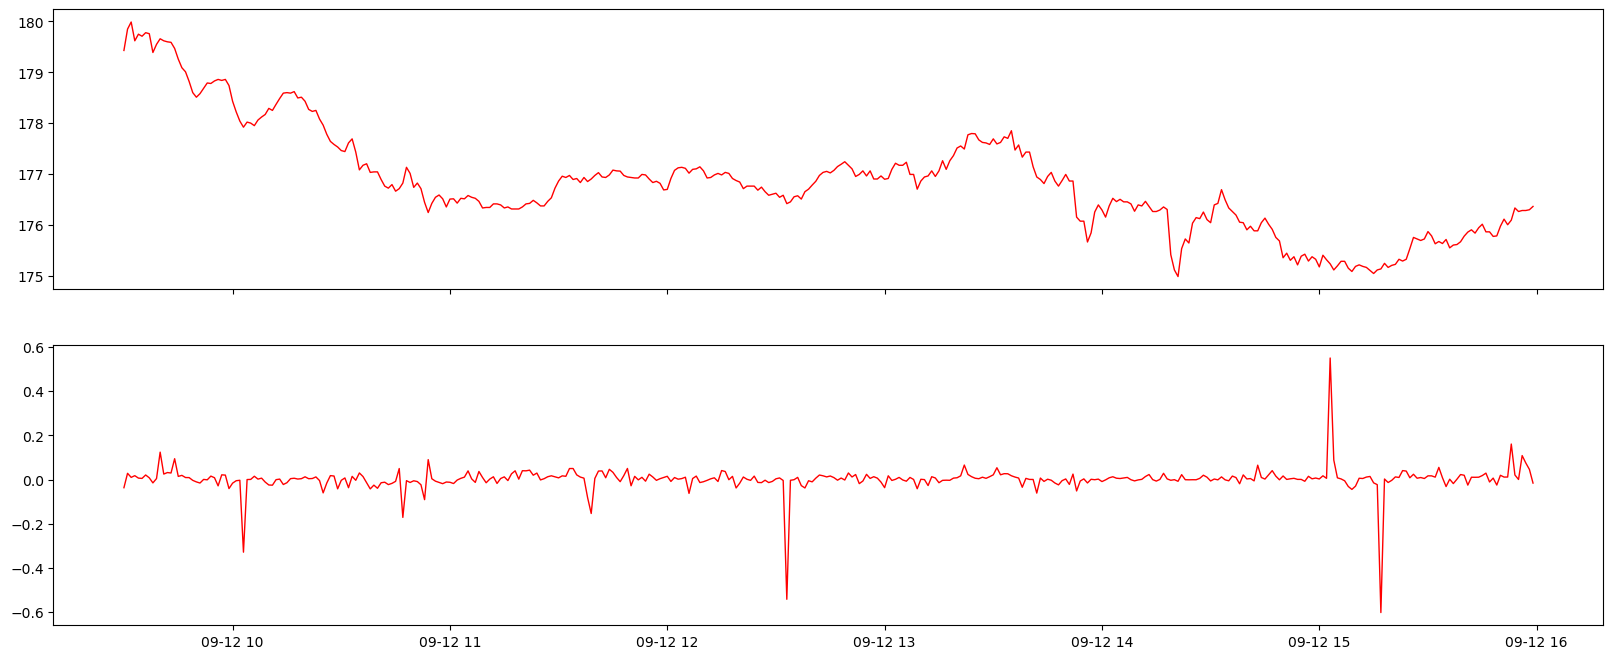

In [52]:
plot_df = trade_df.copy()

fig, ax = plt.subplots(2, 1, figsize=(20,8), sharex=True)
ax[0].plot(plot_df.index, plot_df['Price'], linestyle='-', color='r', linewidth=1)
ax[1].plot(plot_df.index, plot_df['oib'], linestyle='-', color='r', linewidth=1)

# ax.xaxis.set_major_locator(mdates.HourLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
# ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))

# ax.xaxis.grid(True, which='both')
# ax.yaxis.grid(True)

# ax.tick_params(axis="x", which="major", pad=12)
# ax.tick_params(axis="x", which="minor", labelsize=14)

# ax.set_title("Stock Price per minute", fontsize=16)
# ax.set_ylabel("Stock Price", fontsize=14)
# ax.set_xlabel("Hour", fontsize=14);

In [ ]:
plot_df = trade_df.copy()

fig, ax = plt.subplots(2, 1, figsize=(20,8), sharex=True)
ax[0].plot(plot_df.index, plot_df['Price'], linestyle='-', color='r', linewidth=1)
# ax[1].plot(plot_df.index, plot_df['return'], linestyle='-', color='r', linewidth=1)

# ax.xaxis.set_major_locator(mdates.HourLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
# ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))

# ax.xaxis.grid(True, which='both')
# ax.yaxis.grid(True)

# ax.tick_params(axis="x", which="major", pad=12)
# ax.tick_params(axis="x", which="minor", labelsize=14)

# ax.set_title("Stock Price per minute", fontsize=16)
# ax.set_ylabel("Stock Price", fontsize=14)
# ax.set_xlabel("Hour", fontsize=14);

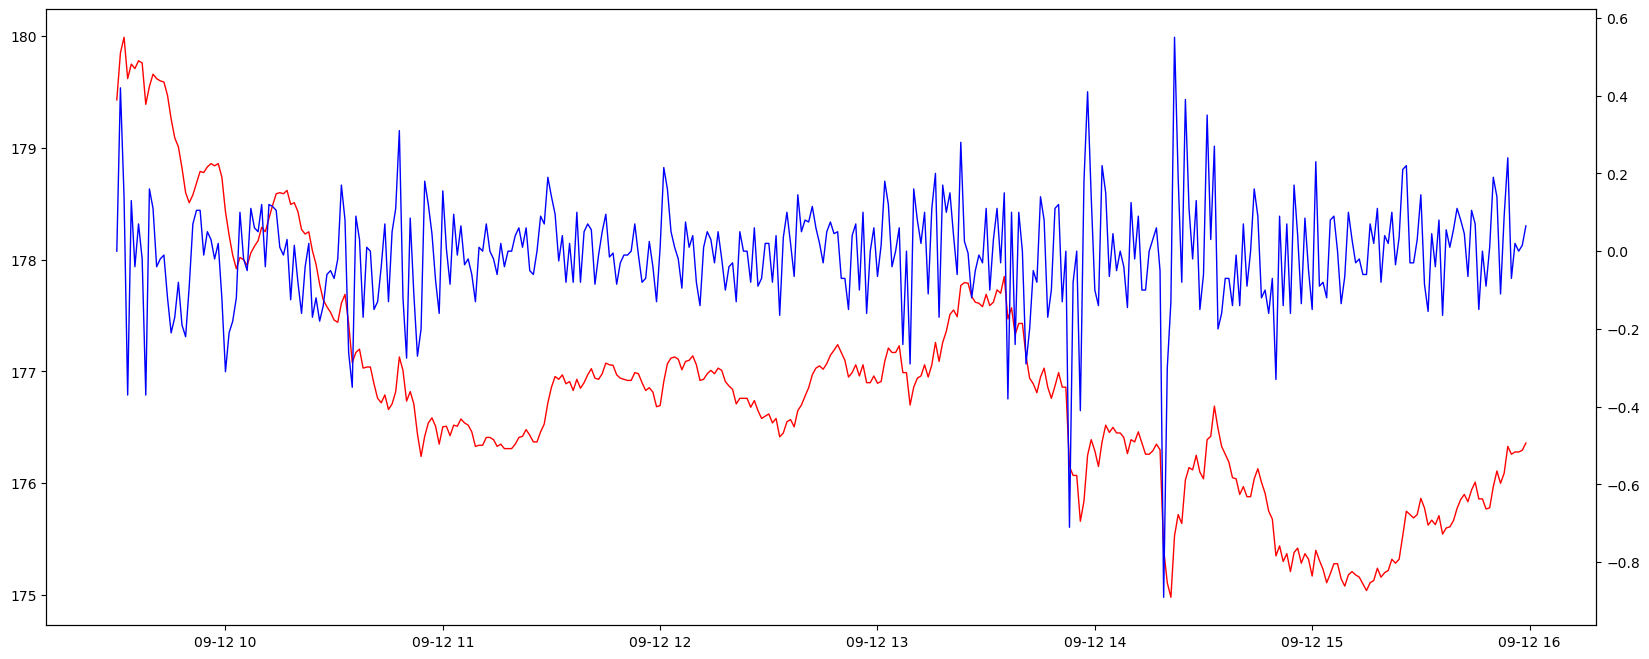

In [41]:
plot_df = trade_df.copy()

fig, ax1 = plt.subplots(1, 1, figsize=(20,8), sharex=True)
ax2 = ax1.twinx()

ax1.plot(plot_df.index, plot_df['Price'], linestyle='-', color='r', linewidth=1)
ax2.plot(plot_df.index, plot_df['price_change'], linestyle='-', color='b', linewidth=1)

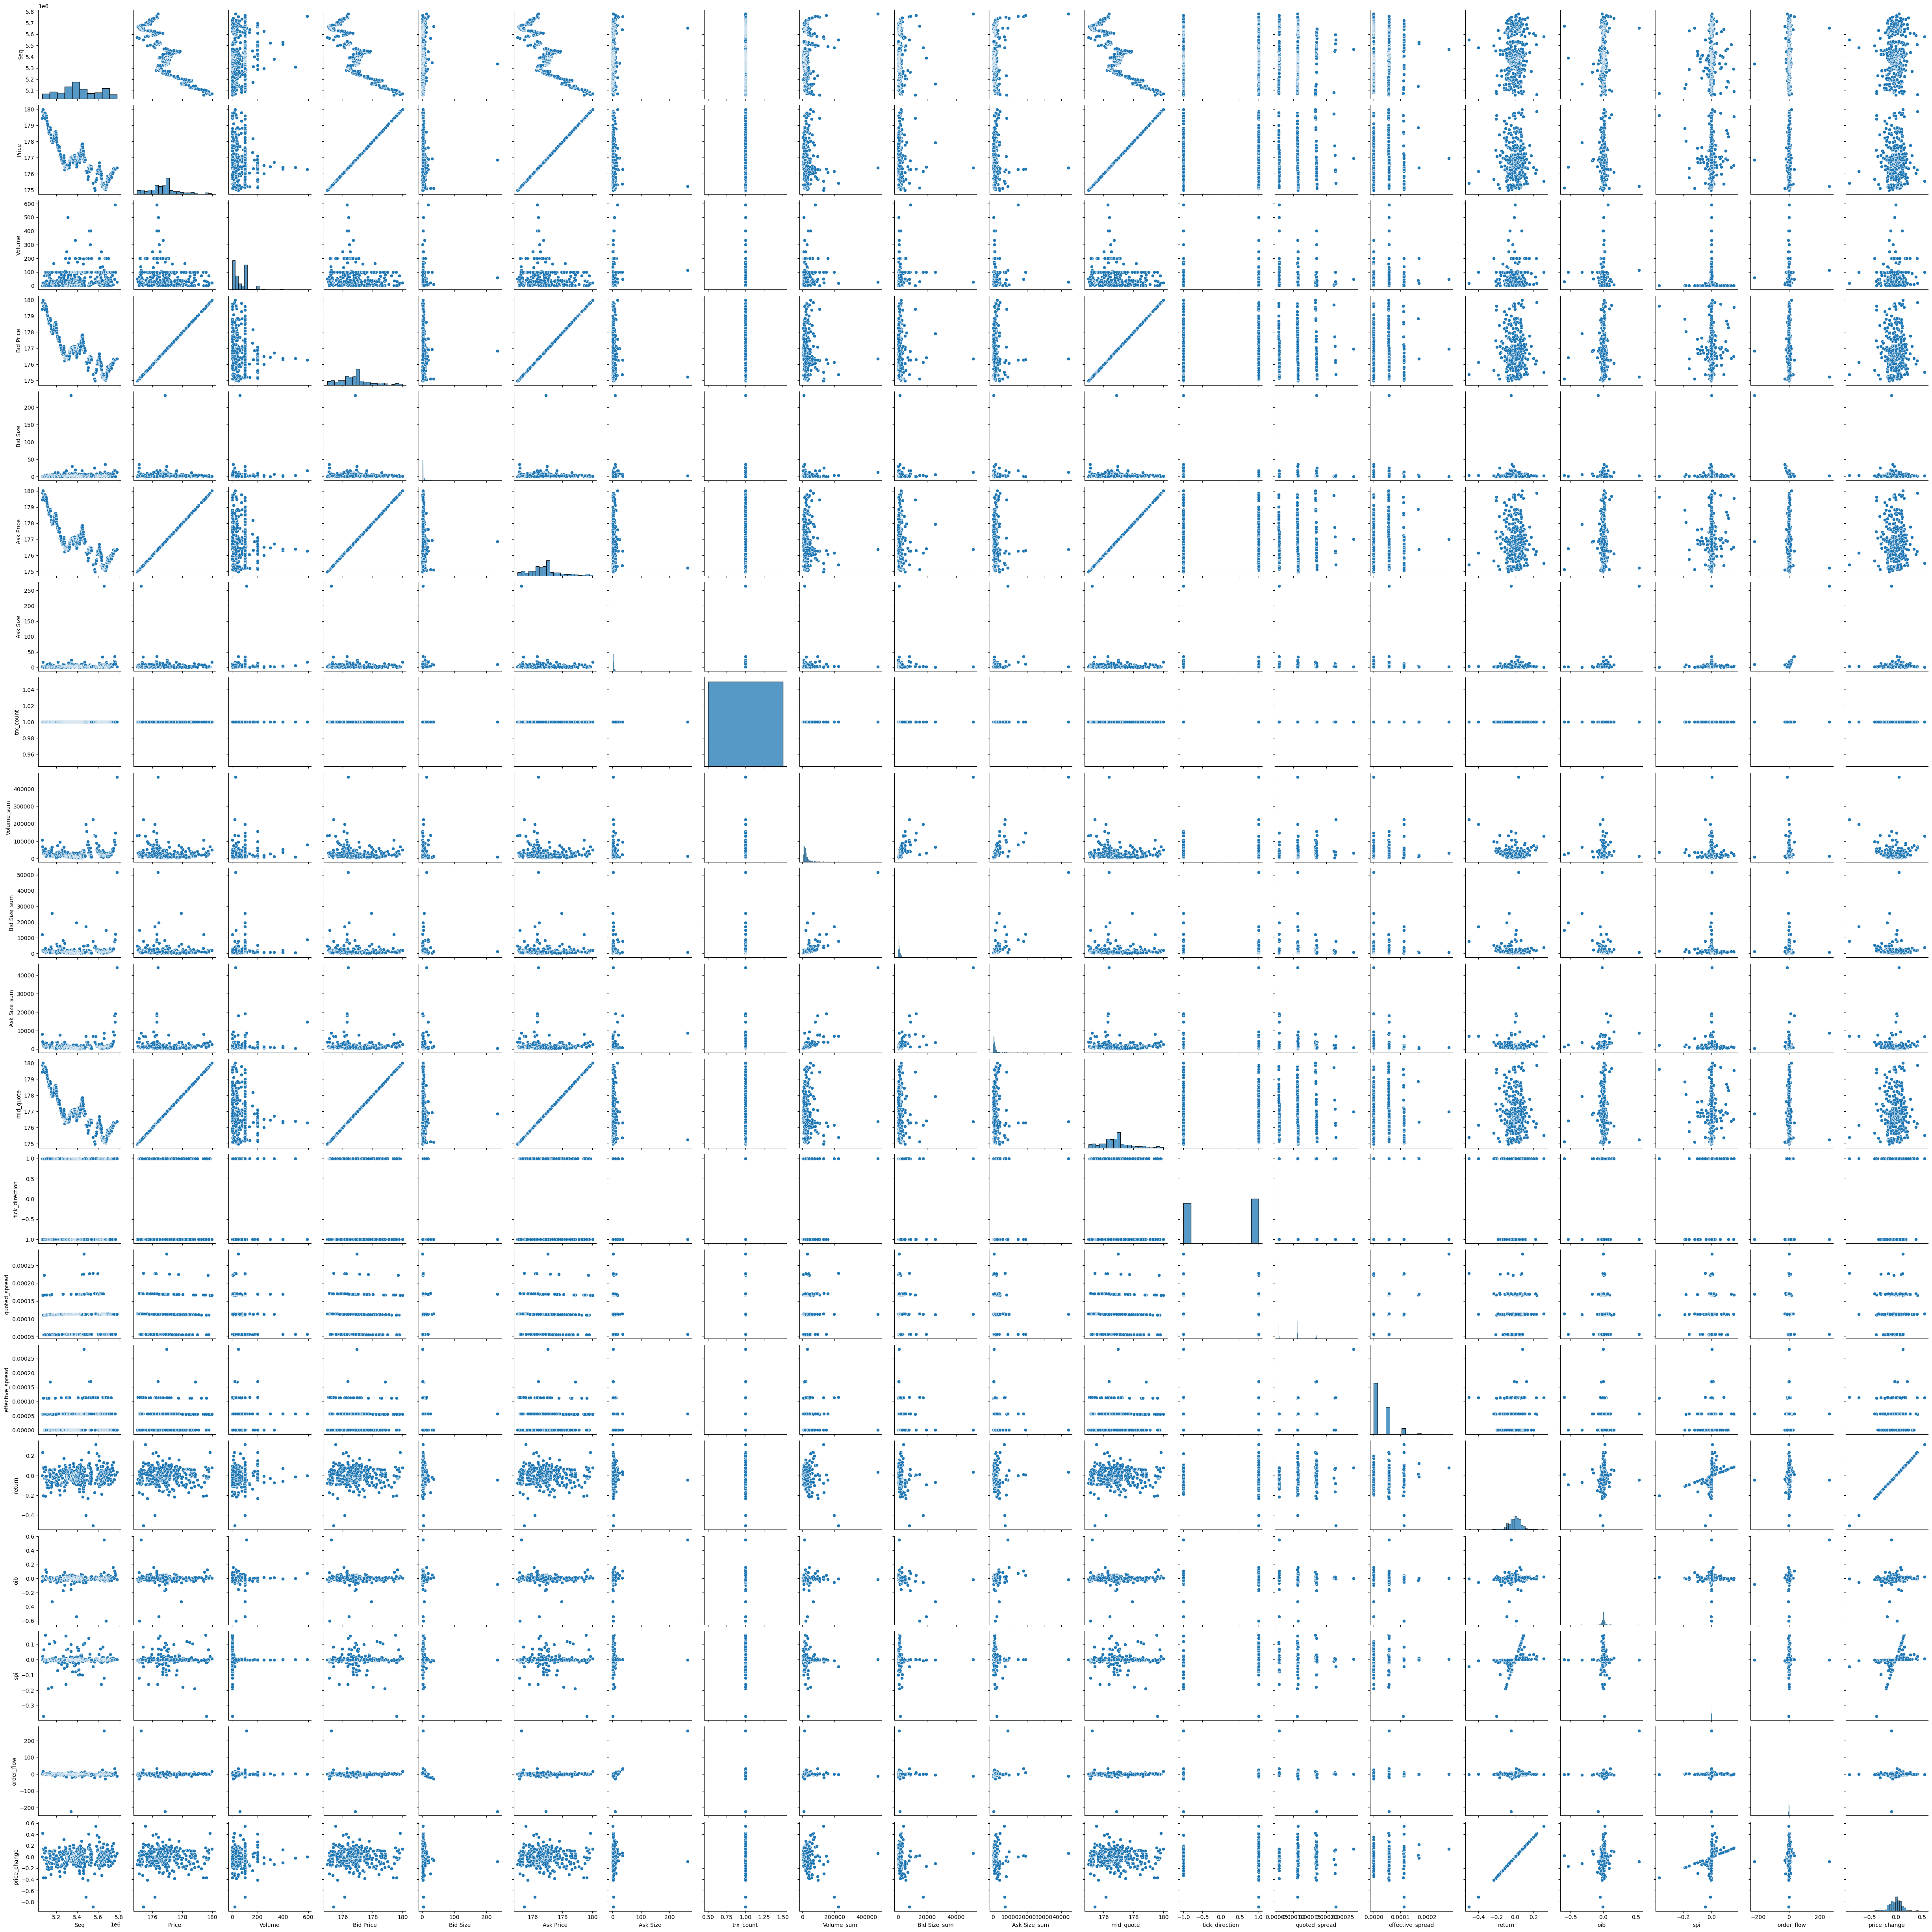

In [42]:


# Create a pair plot
sns.pairplot(trade_df)

# Show the plot
plt.show()

/var/folders/2s/dk287dt92n951wsgxw7y92rc0000gn/T/ipykernel_66719/2978653394.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = trade_df.corr()


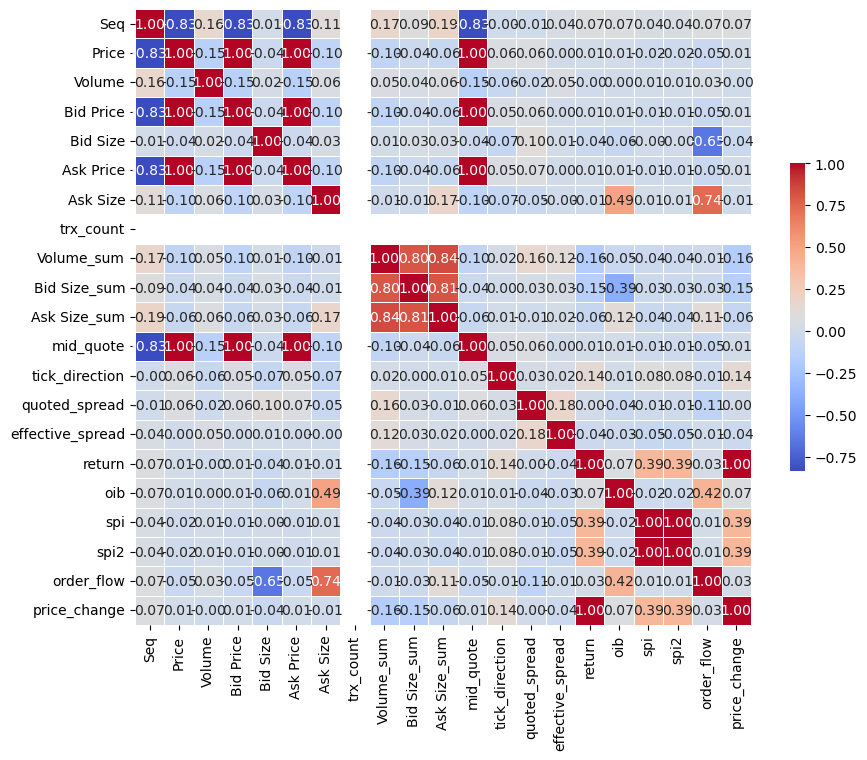

In [35]:
# Calculate the correlation matrix
corr_matrix = trade_df.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, ax=ax, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [57]:
# Example data: replace these with your actual data
delta_p = trade_df['return'] # Change in price or return
oib = trade_df['oib']    # Order Imbalance


In [58]:

# Adding a constant to the OIB data for the intercept (alpha)
oib_with_constant = sm.add_constant(oib)

# Creating the model
model = sm.OLS(delta_p, oib_with_constant)

# Fitting the model
results = model.fit()

# Printing the parameters (alpha and beta)
print("Alpha (intercept) and Beta (coefficient) estimates:")
print(results.params)

# Printing the residuals (epsilon) for each observation
print("\nEpsilon (residuals) for each observation:")
print(results.resid)

Alpha (intercept) and Beta (coefficient) estimates:
const   -0.004538
oib      0.089060
dtype: float64

Epsilon (residuals) for each observation:
Date_Time_recon
2023-09-12 09:30:00    0.007832
2023-09-12 09:31:00    0.236104
2023-09-12 09:32:00    0.081513
2023-09-12 09:33:00   -0.202580
2023-09-12 09:34:00    0.076337
                         ...   
2023-09-12 15:55:00   -0.035185
2023-09-12 15:56:00    0.006240
2023-09-12 15:57:00   -0.002143
2023-09-12 15:58:00    0.008963
2023-09-12 15:59:00    0.042841
Length: 390, dtype: float64


In [59]:
results.rsquared
np.sqrt(results.mse_resid)
results.fvalue

1.7775158059432192

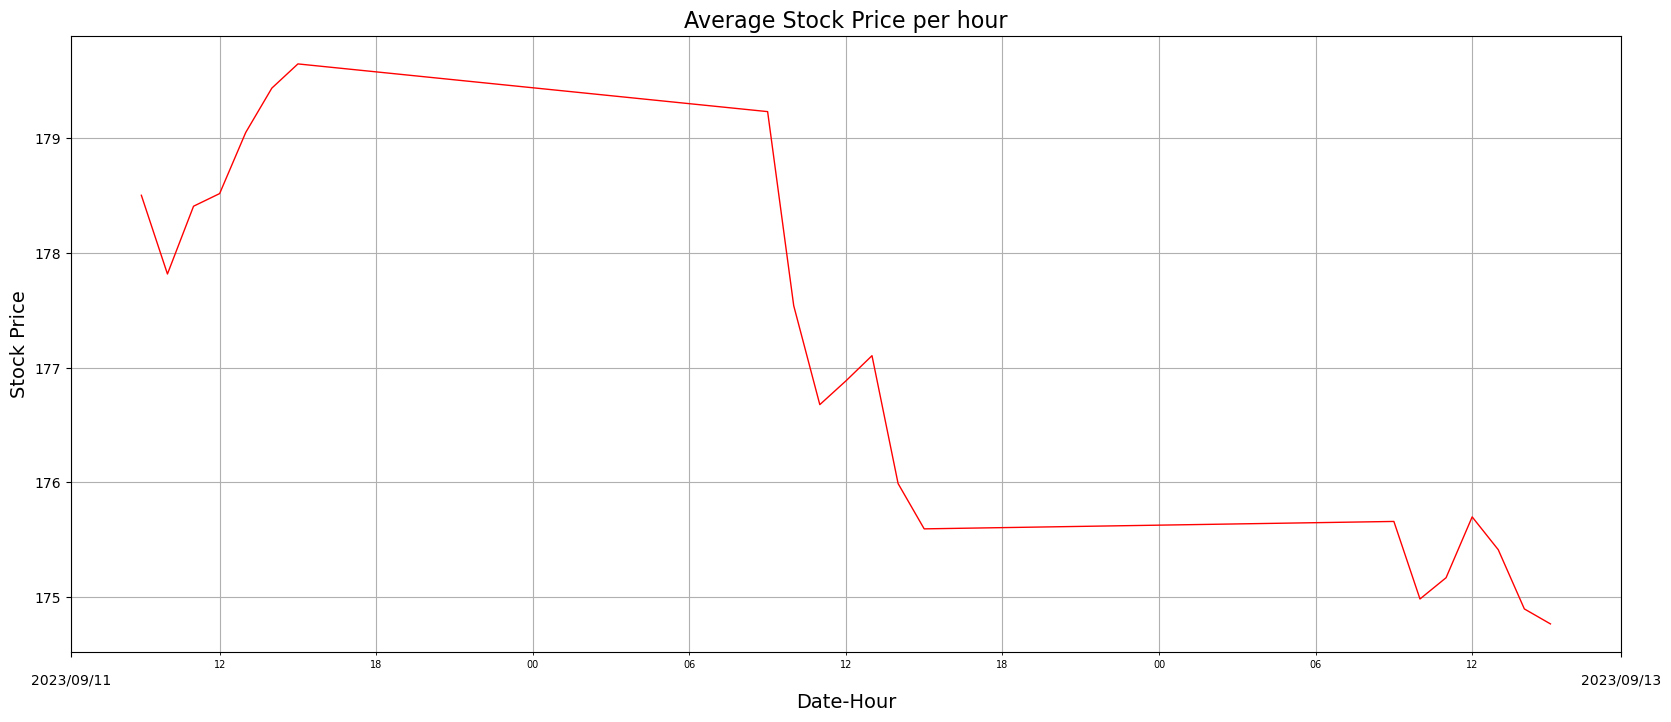

In [18]:
plot_df = trade_df.copy()
plot_df['Date-Hour'] = pd.to_datetime(plot_df['Date-Time_ntz']).dt.strftime("%Y-%m-%d %H")

gr_df = plot_df.groupby('Date-Hour')['Price'].mean().reset_index()
gr_df['Date-Hour'] = pd.to_datetime(gr_df['Date-Hour'], format="%Y-%m-%d %H")

fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot(gr_df['Date-Hour'], gr_df['Price'], linestyle='-', color='r', linewidth=1)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.xaxis.set_minor_locator(mdates.HourLocator((0,6,12,18,)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

ax.xaxis.grid(True, which='both')
ax.yaxis.grid(True)

ax.tick_params(axis="x", which="major", pad=12)
ax.tick_params(axis="x", which="minor", labelsize=7)

ax.set_title("Average Stock Price per hour", fontsize=16)
ax.set_ylabel("Stock Price", fontsize=14)
ax.set_xlabel("Date-Hour", fontsize=14);

In [8]:
# datetimes_list = []
# last_df = clean_df.loc[~clean_df.index.duplicated(keep='last')].copy()
# current_date = pd.to_datetime(last_df.index.min().strftime("%F %H:%M:59"))
# interval = timedelta(minutes=1)

# while current_date <= pd.to_datetime(last_df.index.max().strftime("%F %H:%M:59")):
#     datetimes_list.append(current_date)
#     current_date += interval

# matches_index = last_df.index.get_indexer(datetimes_list, method='pad')
# min1_df = last_df.iloc[matches_index,:]